In [1]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import os
import joblib

In [2]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("NLTK resources checked/downloaded.")

NLTK resources checked/downloaded.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews")

# Step 1: Initial Exploration and Dataset Understanding

In [ ]:
try:
    df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')
    print(f"Dataset loaded successfully. Total reviews: {len(df)}")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'Reviews.csv' not found. Make sure you have downloaded the dataset using opendatasets.")
    print("Expected path: 'amazon-fine-food-reviews/Reviews.csv'")
    exit()

Dataset loaded successfully. Total reviews: 568454
First 5 rows of the dataset:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  


In [ ]:
df['Text'] = df['Text'].astype(str)

In [ ]:
sweet_reviews_df = df[df['Text'].str.contains(r'\bsweet\b', case=False, na=False)].copy()
print(f"\Sweet Reviews: {len(sweet_reviews_df)}")

\Sweet Reviews: 41160


In [ ]:
def get_sweet_context(text, keyword='sweet', window_size=5):
    tokens = nltk.word_tokenize(text.lower())
    keyword_lower = keyword.lower()
    contexts = []
    keyword_indices = [i for i, token in enumerate(tokens) if token == keyword_lower]

    for idx in keyword_indices:
        start_idx = max(0, idx - window_size)
        end_idx = min(len(tokens), idx + window_size + 1)

        context_tokens = tokens[start_idx:end_idx]
        contexts.append(" ".join(context_tokens))
    return contexts


In [ ]:
all_sweet_contexts = []
for text in sweet_reviews_df['Text']:
    all_sweet_contexts.extend(get_sweet_context(text, window_size=5))

In [ ]:
print(f"Total extracted: {len(all_sweet_contexts)}")
print("Sweet Talks:")
for i, context in enumerate(all_sweet_contexts[:5]):
    print(f"{i+1}. {context}")

Total extracted: 50241
Sweet Talks:
1. ! it is not too sweet . i like to transfer
2. 's the one with the sweet tooth - they both loved
3. hardy meal , not too sweet , and great for folks
4. enjoyed tea that was this sweet without being too sweet .
5. this sweet without being too sweet . it tastes crisp .


In [ ]:
all_context_words = []
for context in all_sweet_contexts:
    all_context_words.extend(nltk.word_tokenize(context))

In [ ]:
from collections import Counter
unigram_counts = Counter(all_context_words)
top_unigrams = unigram_counts.most_common(15)
print("Top 15 Unigrams Sweet Talks:")
for word, count in top_unigrams:
    print(f"'{word}': {count}")

Top 15 Unigrams Sweet Talks:
'sweet': 52501
'.': 27984
',': 26260
'and': 20105
'a': 14270
'the': 13789
'it': 12789
'not': 11117
'is': 10995
'i': 10111
'too': 9474
'but': 7279
'to': 6190
'of': 5944
'are': 5713


In [ ]:
bigram_counts = Counter(nltk.ngrams(all_context_words, 2))
top_bigrams = bigram_counts.most_common(15)
print("Top 15 Bigrams Sweet Talks:")
for bigram, count in top_bigrams:
    print(f"'{' '.join(bigram)}': {count}")

Top 15 Bigrams Sweet Talks:
'too sweet': 7863
'sweet ,': 7467
'sweet .': 6232
'sweet and': 6120
'not too': 4162
'. it': 3858
'. i': 3595
', but': 3522
'it 's': 3067
'a sweet': 3038
'sweet potato': 3025
', and': 2978
'it is': 2937
'the sweet': 2736
'and sweet': 2384


In [ ]:
trigram_counts = Counter(nltk.ngrams(all_context_words, 3))
top_trigrams = trigram_counts.most_common(15)
print("Top 15 Trigrams Sweet Talks:")
for trigram, count in top_trigrams:
    print(f"'{' '.join(trigram)}': {count}")

Top 15 Trigrams Sweet Talks:
'not too sweet': 3586
'too sweet .': 1970
'too sweet ,': 1733
'sweet , but': 1419
'sweet . i': 1271
'. it 's': 1259
'. it is': 1179
'< br /': 1159
'too sweet and': 1100
'too sweet for': 1077
'sweet , and': 1069
'br / >': 1020
'. they are': 939
'. < br': 933
'not overly sweet': 925


In [ ]:
def plot_top_ngrams(ngram_list, title, n=15):
    labels, values = zip(*ngram_list)
    labels = [' '.join(label) if isinstance(label, tuple) else label for label in labels] # Join tuple for display

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(values), y=list(labels), palette='YlOrBr_r', hue=list(labels), legend=False) # Modified line
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('N-gram', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

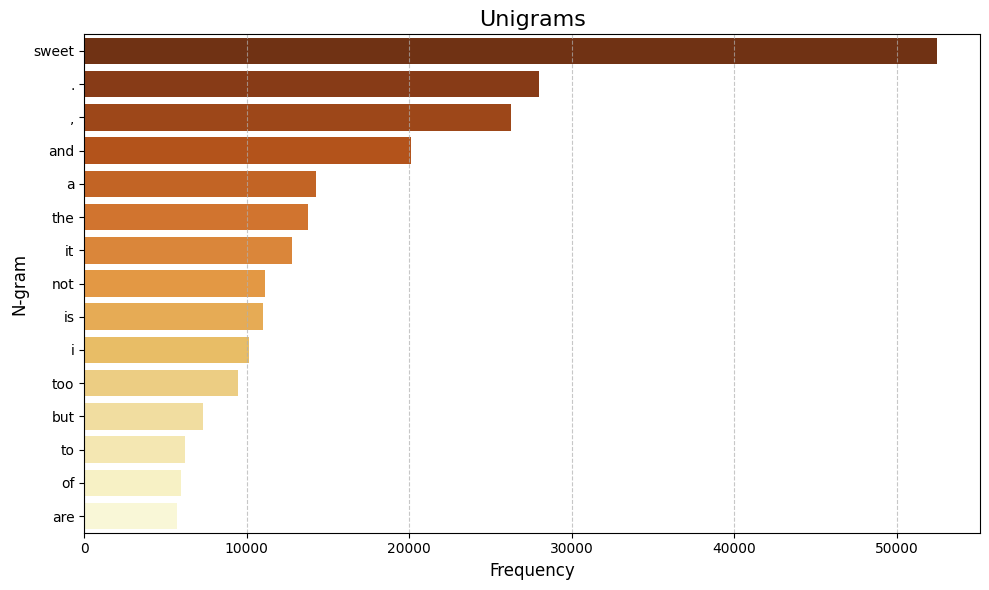

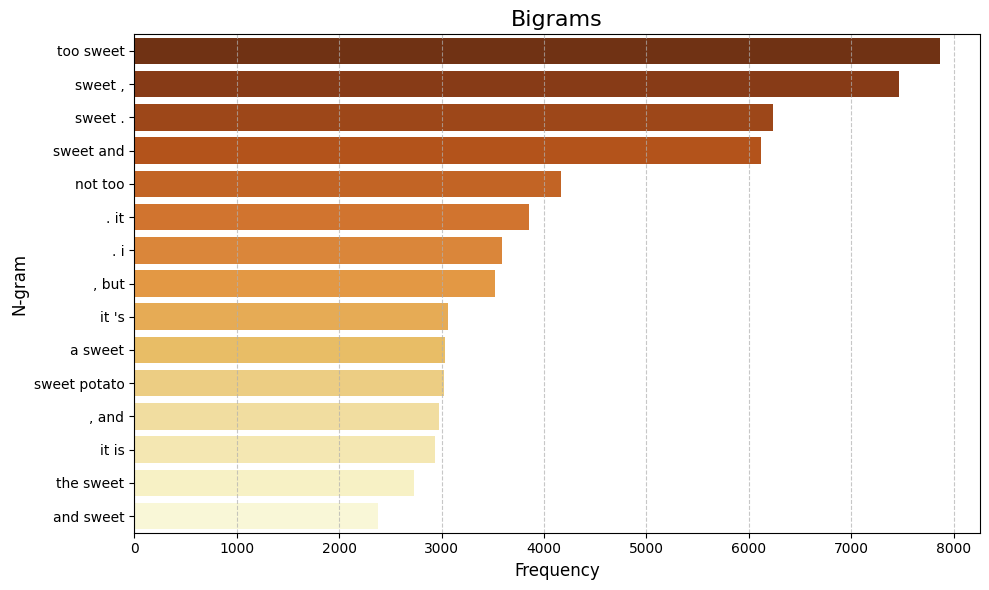

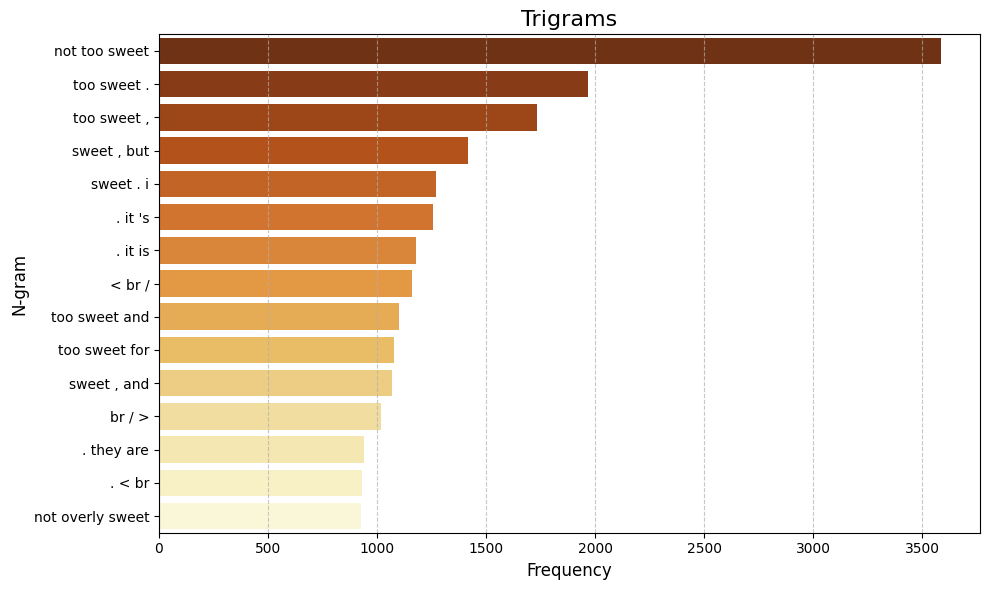

In [ ]:
plot_top_ngrams(top_unigrams, 'Unigrams')
plot_top_ngrams(top_bigrams, 'Bigrams')
plot_top_ngrams(top_trigrams, 'Trigrams')

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return 'neutral'
    vs = analyzer.polarity_scores(text)
    if vs['compound'] >= 0.05:
        return 'positive'
    elif vs['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
df['overall_sentiment'] = df['Text'].apply(get_vader_sentiment)

In [ ]:
sentiment_counts = df['overall_sentiment'].value_counts()
sentiment_percentages = df['overall_sentiment'].value_counts(normalize=True) * 100

In [ ]:
print(sentiment_counts)

print(sentiment_percentages)

overall_sentiment
positive    496967
negative     59333
neutral      12154
Name: count, dtype: int64
overall_sentiment
positive    87.424312
negative    10.437608
neutral      2.138080
Name: proportion, dtype: float64


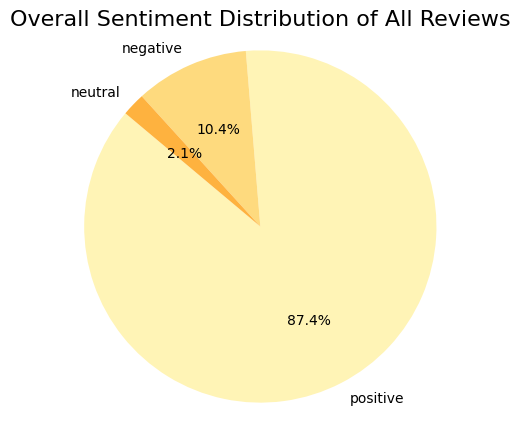

In [ ]:
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('YlOrBr'))
plt.title('Overall Sentiment Distribution of All Reviews', fontsize=16)
plt.axis('equal')
plt.show()

In [ ]:
df.to_csv('amazon-fine-food-reviews/reviews_overall.csv', index=False)

In [ ]:
sweet_reviews_df.to_csv('amazon-fine-food-reviews/sweet_reviews.csv', index=False)

# Step 2: Data Cleaning & Preparation

In [ ]:
import spacy

In [ ]:
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("SpaCy model 'en_core_web_sm' not found. Downloading...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

In [ ]:
try:
    df_sweet_reviews = pd.read_csv('amazon-fine-food-reviews/sweet_reviews.csv')
    print(f"Total Sweet Reviews: {len(df_sweet_reviews)}")
    print(df_sweet_reviews.head(5))
except FileNotFoundError:
    print("Error: 'file not found")
    exit()

Total Sweet Reviews: 41160
   Id   ProductId          UserId                ProfileName  \
0  17  B001GVISJM  A3KLWF6WQ5BNYO             Erica Neathery   
1  29  B00144C10S  A2F4LZVGFLD1OB                     DaisyH   
2  36  B001EO5QW8  A2CI0RLADCRKPF                 T. J. Ryan   
3  80  B005R8JE8O  A3H1EQD2PBC085                        jmc   
4  83  B003ZFRKGO  A2VOZX7YBT0D6D  Johnnycakes "Johnnycakes"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       0      2  1348099200   
1                     0                       0      5  1338854400   
2                     3                       3      4  1210464000   
3                     0                       0      5  1344902400   
4                    15                      15      5  1325635200   

                                             Summary  \
0                                         poor taste   
1                                             YUMMY!   

In [ ]:
df_sweet_reviews['Text'] = df_sweet_reviews['Text'].astype(str)

In [ ]:
custom_stopwords = nlp.Defaults.stop_words - {"not", "no", "nor", "never", "nothing", "nowhere", "too", "than", "some", "into", "over", "any", "few", "more", "most", "just"}

In [ ]:
def clean_text_spacy(text):

    doc = nlp(text.lower())

    cleaned_tokens = []
    for token in doc:
        if not token.is_punct and not token.is_space and \
           token.lemma_ not in custom_stopwords and \
           len(token.lemma_) > 1:
            if token.like_num:
                continue
            cleaned_tokens.append(token.lemma_)

    return " ".join(cleaned_tokens)

In [ ]:
df_sweet_reviews['cleaned_text'] = df_sweet_reviews['Text'].apply(clean_text_spacy)

In [ ]:
print("Before vs. After Cleaning:")
for i in range(min(5, len(df_sweet_reviews))):
    original = df_sweet_reviews.iloc[i]['Text']
    cleaned = df_sweet_reviews.iloc[i]['cleaned_text']
    print(f"\nOriginal: {original[:500]}...")
    print(f"Cleaned:  {cleaned[:500]}...")

Before vs. After Cleaning:

Original: I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to transfer them to a zip lock baggie so they stay fresh so I can take my time eating them....
Cleaned:  love eat good watch tv look movie not too sweet like transfer zip lock baggie stay fresh time eat...

Original: I got this for my Mum who is not diabetic but needs to watch her sugar intake, and my father who simply chooses to limit unnecessary sugar intake - she's the one with the sweet tooth - they both LOVED these toffees, you would never guess that they're sugar-free and it's so great that you can eat them pretty much guilt free!  i was so impressed that i've ordered some for myself (w dark chocolate) to take to the office so i'll eat them instead of snacking on sugary sweets.<br />These are just EXCE...
Cleaned:  mum not diabetic need watch sugar intake father simply choose limit unnecessary sugar intake sweet tooth love toffee never gues

In [ ]:
df_sweet_reviews['original_word_count'] = df_sweet_reviews['Text'].apply(lambda x: len(x.split()))
df_sweet_reviews['cleaned_word_count'] = df_sweet_reviews['cleaned_text'].apply(lambda x: len(x.split()))

In [ ]:
print("\nDescriptive statistics for Original Word Count:")
print(df_sweet_reviews['original_word_count'].describe())
print("\nDescriptive statistics for Cleaned Word Count:")
print(df_sweet_reviews['cleaned_word_count'].describe())


Descriptive statistics for Original Word Count:
count    41160.000000
mean       121.950413
std        123.783970
min          8.000000
25%         50.000000
50%         87.000000
75%        147.000000
max       2092.000000
Name: original_word_count, dtype: float64

Descriptive statistics for Cleaned Word Count:
count    41160.00000
mean        59.49757
std         61.95615
min          4.00000
25%         24.00000
50%         41.00000
75%         71.00000
max       1084.00000
Name: cleaned_word_count, dtype: float64


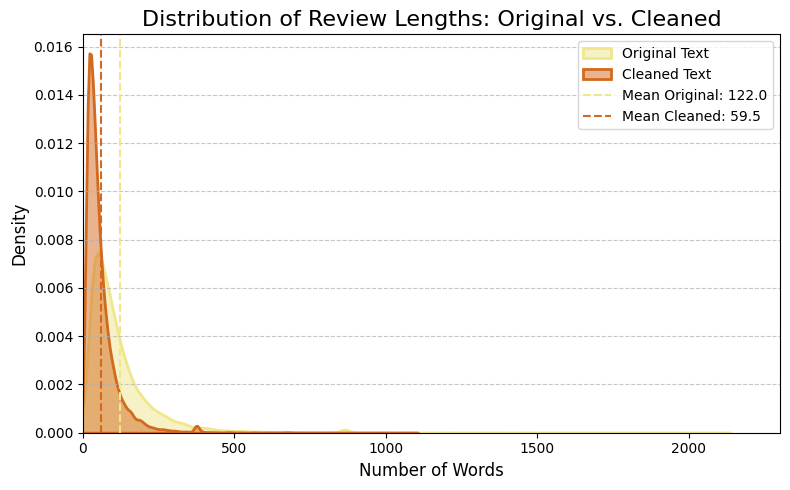

In [ ]:
if df_sweet_reviews['original_word_count'].sum() == 0 and df_sweet_reviews['cleaned_word_count'].sum() == 0:
    print("No meaningful data to plot")
else:
    plt.figure(figsize=(8, 5))

    sns.kdeplot(df_sweet_reviews['original_word_count'], color='khaki', label='Original Text', fill=True, alpha=0.5, linewidth=2)
    sns.kdeplot(df_sweet_reviews['cleaned_word_count'], color='chocolate', label='Cleaned Text', fill=True, alpha=0.5, linewidth=2)

    mean_original = df_sweet_reviews['original_word_count'].mean()
    mean_cleaned = df_sweet_reviews['cleaned_word_count'].mean()
    plt.axvline(mean_original, color='khaki', linestyle='--', label=f'Mean Original: {mean_original:.1f}')
    plt.axvline(mean_cleaned, color='chocolate', linestyle='--', label=f'Mean Cleaned: {mean_cleaned:.1f}')

    plt.title('Distribution of Review Lengths: Original vs. Cleaned', fontsize=16)
    plt.xlabel('Number of Words', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    max_original_word_count = df_sweet_reviews['original_word_count'].max()

    dynamic_xlim = max(10, max_original_word_count * 1.1)
    plt.xlim(0, dynamic_xlim)

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
df_sweet_reviews.to_csv('amazon-fine-food-reviews/sweet_reviews_cleaned.csv', index=False)

# Step 3: Manual Labeling

In [ ]:
try:
    df_cleaned_reviews = pd.read_csv('amazon-fine-food-reviews/sweet_reviews_cleaned.csv')
    if df_cleaned_reviews.empty:
        print("Can't proceed with sampling.")
        exit()
    print(f"Total reviews: {len(df_cleaned_reviews)}")
    print("First 3 rows of the cleaned dataset:")
    print(df_cleaned_reviews.head(3))
except FileNotFoundError:
    print("File not found")
    exit()

Total reviews: 41160
First 3 rows of the cleaned dataset:
   Id   ProductId          UserId     ProfileName  HelpfulnessNumerator  \
0  17  B001GVISJM  A3KLWF6WQ5BNYO  Erica Neathery                     0   
1  29  B00144C10S  A2F4LZVGFLD1OB          DaisyH                     0   
2  36  B001EO5QW8  A2CI0RLADCRKPF      T. J. Ryan                     3   

   HelpfulnessDenominator  Score        Time     Summary  \
0                       0      2  1348099200  poor taste   
1                       0      5  1338854400      YUMMY!   
2                       3      4  1210464000  satisfying   

                                                Text  \
0  I love eating them and they are good for watch...   
1  I got this for my Mum who is not diabetic but ...   
2  McCann's Instant Irish Oatmeal, Variety Pack o...   

                                        cleaned_text  original_word_count  \
0  love eat good watch tv look movie not too swee...                   42   
1  mum not diabetic n

In [ ]:
df_cleaned_reviews['cleaned_text'] = df_cleaned_reviews['cleaned_text'].astype(str)

In [ ]:
sample_size = 100
if len(df_cleaned_reviews) < sample_size:
    print(f"Dataset has only {len(df_cleaned_reviews)} reviews")
    manual_labeling_sample = df_cleaned_reviews.copy()
else:
    manual_labeling_sample = df_cleaned_reviews.sample(n=sample_size, random_state=42).copy()

In [ ]:
manual_labeling_sample['sentiment_label'] = ''

In [ ]:
sample_csv_path_export = 'amazon-fine-food-reviews/manual_labeling_sample.csv'

In [ ]:
sample_csv_path_import = 'amazon-fine-food-reviews/manual_labeling_sample_done.csv'

Total labeled reviews: 100
5 rows of labeled data:
        Id   ProductId          UserId                           ProfileName  \
31  244588  B002Z08ROO   AY12DBB0U420B                         Gary Peterson   
55  437838  B005A1LGIY  A38BEIB5NCPXBR               Stori Diva "Stori Gurl"   
64   16625  B001LGGH40  A2L6QS8SVHT9RG  randomartco "period film aficionado"   
83  368582  B005K4Q1W2  A2GR7SRMJ54RG7                             Book Vamp   
43  135942  B005SPQENY  A2AYYKD4OODSLY           April E. "A homeschool Mom"   

    HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
31                     1                       1      3  1343520000   
55                     0                       0      4  1319673600   
64                     0                       0      4  1239753600   
83                     0                       0      5  1321488000   
43                     0                       0      4  1330819200   

                                         

/tmp/ipython-input-12-4026119070.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='YlOrBr_r')


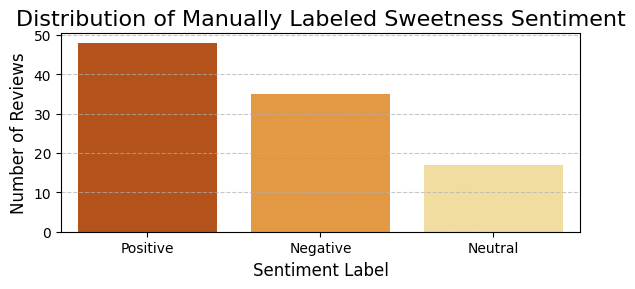

In [ ]:
try:
    labeled_data = pd.read_csv(sample_csv_path_import)
    if labeled_data['sentiment_label'].isnull().all() or (labeled_data['sentiment_label'] == '').all():
        exit()
    print(f"Total labeled reviews: {len(labeled_data)}")
    print("5 rows of labeled data:")
    print(labeled_data.sample(5))

    label_counts = labeled_data['sentiment_label'].value_counts()
    label_percentages = labeled_data['sentiment_label'].value_counts(normalize=True) * 100

    print("Distribution of Manually Labeled Sweetness Sentiment:")
    print(label_counts)
    print("Percentage Distribution:")
    print(label_percentages)

    plt.figure(figsize=(6, 3))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='YlOrBr_r')
    plt.title('Distribution of Manually Labeled Sweetness Sentiment', fontsize=16)
    plt.xlabel('Sentiment Label', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    labeled_data.to_csv('amazon-fine-food-reviews/sweet_reviews_manually_labeled_sample.csv', index=False)

except FileNotFoundError:
    print(f"file not found")
except Exception as e:
    print(f"error occurred while loading {e}")

# Step 4: Feature Engineering


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [4]:
labeled_data_path = 'amazon-fine-food-reviews/manual_labeling_sample_done.csv'

In [5]:
try:
    df_labeled = pd.read_csv(labeled_data_path)
    if df_labeled.empty:
        exit()
    df_labeled['cleaned_text'] = df_labeled['cleaned_text'].astype(str)
    df_labeled['sentiment_label'] = df_labeled['sentiment_label'].astype(str)
    print(f"Total labeled reviews: {len(df_labeled)}")
    print("First 3 rows of the labeled dataset:")
    print(df_labeled.sample(3))
except FileNotFoundError:
    exit()
except KeyError as e:
    exit()

Total labeled reviews: 100
First 3 rows of the labeled dataset:
        Id   ProductId         UserId    ProfileName  HelpfulnessNumerator  \
18  120566  B005K4Q37A  A7FRLYY9RN0IH    Slackerhobo                     0   
44  103416  B001CU0N7C  ALWG57JEKN9DV  Jacob Mathias                     1   
94  166718  B000TMS0QA  ATOSJC5YT3CVT  A. Lowdermilk                     0   

    HelpfulnessDenominator  Score        Time  \
18                       0      2  1327276800   
44                       2      4  1307232000   
94                       0      5  1314057600   

                                         Summary  \
18  Love the flavor damage to cups un-acceptable   
44                            Good protein snack   
94  Tastes really good considering ZERO calories   

                                                 Text  \
18  Love the flavor of these cappuccino cups they ...   
44  I got these because I don't usually like the g...   
94  If you're looking for an exact replica of 

In [6]:
analyzer = SentimentIntensityAnalyzer()

In [7]:
def get_vader_scores(text):
    if not isinstance(text, str):
        return {'pos': 0.0, 'neu': 0.0, 'neg': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

In [8]:
vader_scores = df_labeled['cleaned_text'].apply(get_vader_scores).apply(pd.Series)

In [9]:
original_vader_cols = ['compound_vader', 'pos_vader', 'neg_vader', 'neu_vader']

In [10]:
cols_to_drop = [col for col in original_vader_cols if col in df_labeled.columns]

if cols_to_drop:
    df_labeled = df_labeled.drop(columns=cols_to_drop)

In [11]:
vader_scores.columns = [f'{col}_vader' for col in vader_scores.columns]

In [12]:
df_labeled = pd.concat([df_labeled, vader_scores], axis=1)
print(df_labeled[['cleaned_text', 'compound_vader', 'pos_vader', 'neg_vader', 'neu_vader']].head())

                                        cleaned_text  compound_vader  \
0  calorie cup coffee fat description mildly swee...          0.9515   
1  just brew coffee think smell taste awful sucra...         -0.2228   
2  buy accident decide chance not worth real pean...          0.8869   
3  let adult maybe affect taste hand not sweet to...          0.9581   
4  cafe escape think sweet chai latte hot chocola...         -0.1779   

   pos_vader  neg_vader  neu_vader  
0      0.340      0.094      0.565  
1      0.203      0.270      0.527  
2      0.306      0.090      0.604  
3      0.269      0.102      0.629  
4      0.226      0.217      0.557  


In [13]:
negation_words = {"not", "no", "nor", "never", "nothing", "nowhere", "hardly", "barely", "scarcely", "than", "some", "into", "over", "any", "few", "more", "most", "just"}
intensifier_words = {"very", "extremely", "highly", "really", "so", "too", "quite", "somewhat", "slightly"}

In [14]:
def contains_negation(text, neg_words):
    tokens = text.split()
    return 1 if any(word in tokens for word in neg_words) else 0

In [15]:
def contains_intensifier(text, int_words):
    tokens = text.split()
    return 1 if any(word in tokens for word in int_words) else 0

In [16]:
df_labeled['has_negation'] = df_labeled['cleaned_text'].apply(lambda x: contains_negation(x, negation_words))
df_labeled['has_intensifier'] = df_labeled['cleaned_text'].apply(lambda x: contains_intensifier(x, intensifier_words))
print(df_labeled[['cleaned_text', 'has_negation', 'has_intensifier']].head())

                                        cleaned_text  has_negation  \
0  calorie cup coffee fat description mildly swee...             1   
1  just brew coffee think smell taste awful sucra...             1   
2  buy accident decide chance not worth real pean...             1   
3  let adult maybe affect taste hand not sweet to...             1   
4  cafe escape think sweet chai latte hot chocola...             1   

   has_intensifier  
0                1  
1                1  
2                1  
3                1  
4                0  


In [17]:
X = df_labeled[['cleaned_text', 'compound_vader', 'pos_vader', 'neg_vader', 'neu_vader', 'has_negation', 'has_intensifier', 'Score']]
y = df_labeled['sentiment_label']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [19]:
print(f"Training set size: {len(X_train)} reviews")
print(f"Testing set size: {len(X_test)} reviews")
print("\nTraining set sentiment distribution:")
print(y_train.value_counts(normalize=True) * 100)
print("\nTesting set sentiment distribution:")
print(y_test.value_counts(normalize=True) * 100)

Training set size: 75 reviews
Testing set size: 25 reviews

Training set sentiment distribution:
sentiment_label
Positive    48.000000
Negative    34.666667
Neutral     17.333333
Name: proportion, dtype: float64

Testing set sentiment distribution:
sentiment_label
Positive    48.0
Negative    36.0
Neutral     16.0
Name: proportion, dtype: float64


In [20]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

In [21]:
numerical_features = ['compound_vader', 'pos_vader', 'neg_vader', 'neu_vader', 'has_negation', 'has_intensifier', 'Score']

In [22]:
def select_numerical_features(X):
    numerical_features = ['compound_vader', 'pos_vader', 'neg_vader', 'neu_vader', 'has_negation', 'has_intensifier', 'Score']
    return X[numerical_features].values

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', tfidf_vectorizer, 'cleaned_text'),
        ('num_features', FunctionTransformer(func=select_numerical_features, validate=False), numerical_features)
    ],
    remainder='drop'
)

In [23]:
feature_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [24]:
X_train_processed = feature_pipeline.fit_transform(X_train)
X_test_processed = feature_pipeline.transform(X_test)

In [25]:
print(f"shape of processed training data: {X_train_processed.shape}")
print(f"shape of processed testing data: {X_test_processed.shape}")

shape of processed training data: (75, 5007)
shape of processed testing data: (25, 5007)


In [26]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

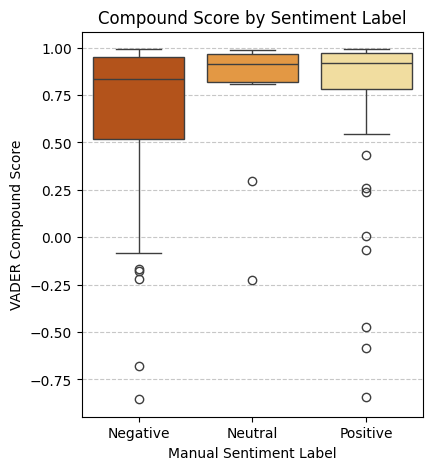

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='sentiment_label', y='compound_vader', data=df_labeled, palette='YlOrBr_r', hue='sentiment_label', legend=False)
plt.title('Compound Score by Sentiment Label')
plt.xlabel('Manual Sentiment Label')
plt.ylabel('VADER Compound Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

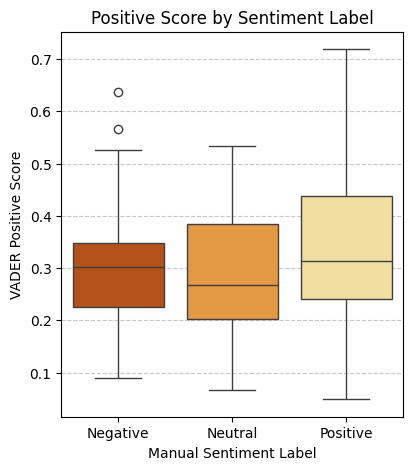

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
sns.boxplot(x='sentiment_label', y='pos_vader', data=df_labeled, palette='YlOrBr_r', hue='sentiment_label', legend=False)
plt.title('Positive Score by Sentiment Label')
plt.xlabel('Manual Sentiment Label')
plt.ylabel('VADER Positive Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

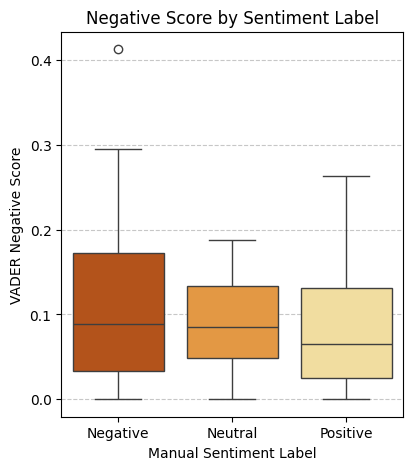

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 3)
sns.boxplot(x='sentiment_label', y='neg_vader', data=df_labeled, palette='YlOrBr_r', hue='sentiment_label', legend=False)
plt.title('Negative Score by Sentiment Label')
plt.xlabel('Manual Sentiment Label')
plt.ylabel('VADER Negative Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [30]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [31]:
numerical_df = df_labeled[numerical_features + ['sentiment_label']]

In [32]:
label_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
numerical_df['sentiment_numeric'] = numerical_df['sentiment_label'].map(label_mapping)

/tmp/ipython-input-32-159750000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df['sentiment_numeric'] = numerical_df['sentiment_label'].map(label_mapping)


In [33]:
correlation_matrix = numerical_df[numerical_features + ['sentiment_numeric']].corr()

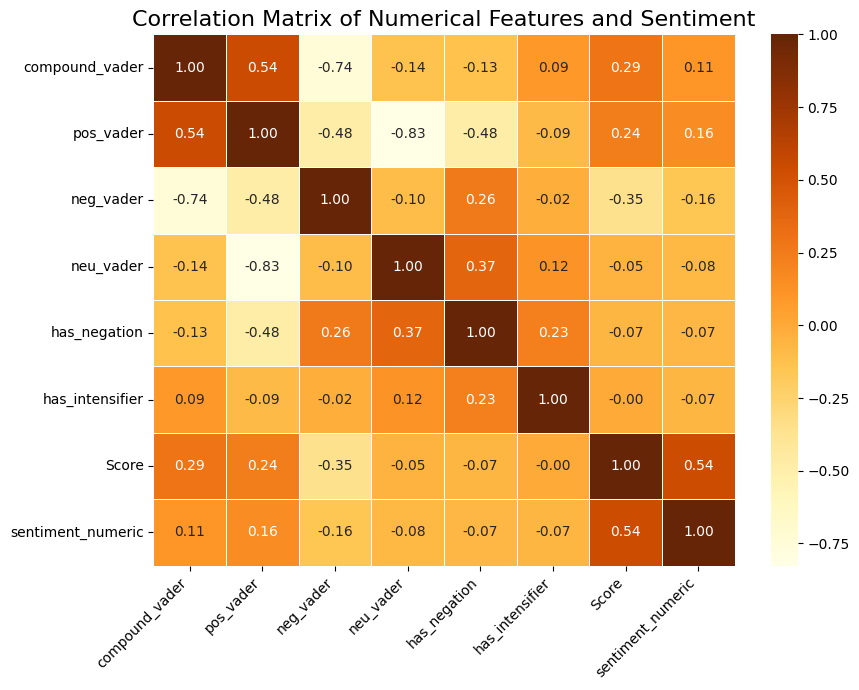

In [34]:
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Sentiment', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 5: Model Selection and Training

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [36]:
labeled_data_path = 'amazon-fine-food-reviews/manual_labeling_sample_done.csv'

In [37]:
try:
    df_labeled = pd.read_csv(labeled_data_path)
    if df_labeled.empty:
        print(f"empty")
        exit()
    df_labeled['cleaned_text'] = df_labeled['cleaned_text'].astype(str)
    df_labeled['sentiment_label'] = df_labeled['sentiment_label'].astype(str)
    print(f"Total labeled reviews: {len(df_labeled)}")
except FileNotFoundError:
    print(f"Missing file")
    exit()
except KeyError as e:
    print(f"Missing column{e}")
    exit()

Total labeled reviews: 100


In [38]:
analyzer = SentimentIntensityAnalyzer()

In [39]:
def get_vader_scores(text):
    if not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

In [40]:
vader_scores = df_labeled['cleaned_text'].apply(get_vader_scores).apply(pd.Series)
df_labeled = pd.concat([df_labeled, vader_scores], axis=1)

In [41]:
negation_words = {"not", "no", "nor", "never", "nothing", "nowhere", "hardly", "barely", "scarcely", "than", "some", "into", "over", "any", "few", "more", "most", "just"}
intensifier_words = {"very", "extremely", "highly", "really", "so", "too", "quite", "somewhat", "slightly"}

In [42]:
def contains_negation(text, neg_words):
    tokens = text.split()
    return 1 if any(word in tokens for word in neg_words) else 0

In [43]:
def contains_intensifier(text, int_words):
    tokens = text.split()
    return 1 if any(word in tokens for word in int_words) else 0

In [44]:
df_labeled['has_negation'] = df_labeled['cleaned_text'].apply(lambda x: contains_negation(x, negation_words))
df_labeled['has_intensifier'] = df_labeled['cleaned_text'].apply(lambda x: contains_intensifier(x, intensifier_words))

In [45]:
X = df_labeled[['cleaned_text', 'compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score']]
y = df_labeled['sentiment_label']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [47]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
numerical_features = ['compound_vader', 'pos_vader', 'neg_vader', 'neu_vader', 'has_negation', 'has_intensifier', 'Score']

In [48]:
def select_numerical_features(X):
    numerical_features = ['compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score']
    return X[numerical_features].values

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', tfidf_vectorizer, 'cleaned_text'),
        ('num_features', FunctionTransformer(func=select_numerical_features, validate=False), ['compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score'])
    ],
    remainder='drop'
)

In [49]:
feature_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [50]:
X_train_processed = feature_pipeline.fit_transform(X_train)
X_test_processed = feature_pipeline.transform(X_test)
print(f"Shape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed testing data: {X_test_processed.shape}")

Shape of processed training data: (75, 5007)
Shape of processed testing data: (25, 5007)


In [51]:
try:
    tfidf_feature_names = feature_pipeline.named_steps['preprocessor'].named_transformers_['text_tfidf'].get_feature_names_out()
    all_feature_names = np.concatenate([tfidf_feature_names, np.array(numerical_features)])
    print(f"Total feature names collected: {len(all_feature_names)}")
except Exception as e:
    print(f"{e}")
    all_feature_names = None

Total feature names collected: 5007


In [52]:
def evaluate_model(model, X_test, y_test, model_name, class_labels):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Performance ---")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    macro_f1 = f1_score(y_test, y_pred, average='macro', labels=class_labels)
    print(f"Macro F1-Score for {model_name}: {macro_f1:.4f}")
    return macro_f1

In [53]:
class_labels = sorted(y.unique())

In [54]:
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

param_grid_lr = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search_lr = GridSearchCV(log_reg_pipeline, param_grid_lr, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

print("Best parameters found for Logistic Regression:")
print(grid_search_lr.best_params_)

best_lr_model = grid_search_lr.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found for Logistic Regression:
{'classifier__C': 100, 'classifier__solver': 'liblinear'}


Best Logistic Regression parameters: {'classifier__C': 100, 'classifier__solver': 'liblinear'}
--- Logistic Regression Performance ---

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.56      0.59         9
     Neutral       0.00      0.00      0.00         4
    Positive       0.59      0.83      0.69        12

    accuracy                           0.60        25
   macro avg       0.40      0.46      0.43        25
weighted avg       0.51      0.60      0.54        25



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


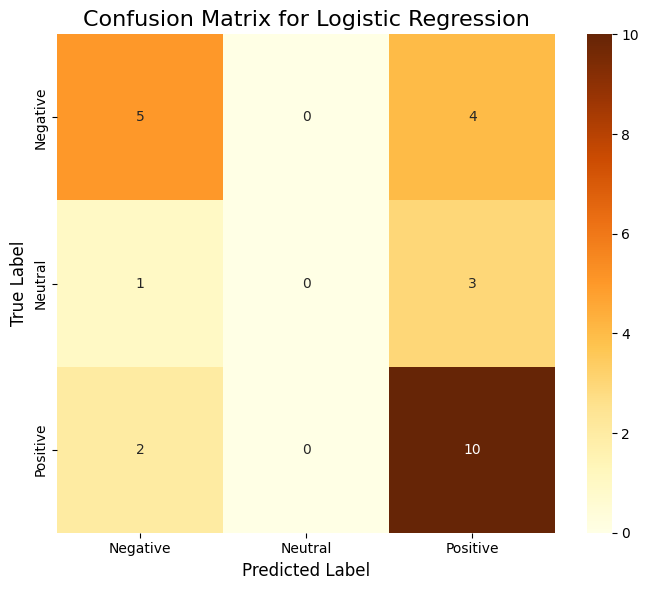

Macro F1-Score for Logistic Regression: 0.4260


In [55]:
best_lr_model = grid_search_lr.best_estimator_
print(f"Best Logistic Regression parameters: {grid_search_lr.best_params_}")
lr_f1 = evaluate_model(best_lr_model, X_test, y_test, "Logistic Regression", class_labels)

/tmp/ipython-input-56-1653440844.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=coef_df, palette='YlOrBr_r')


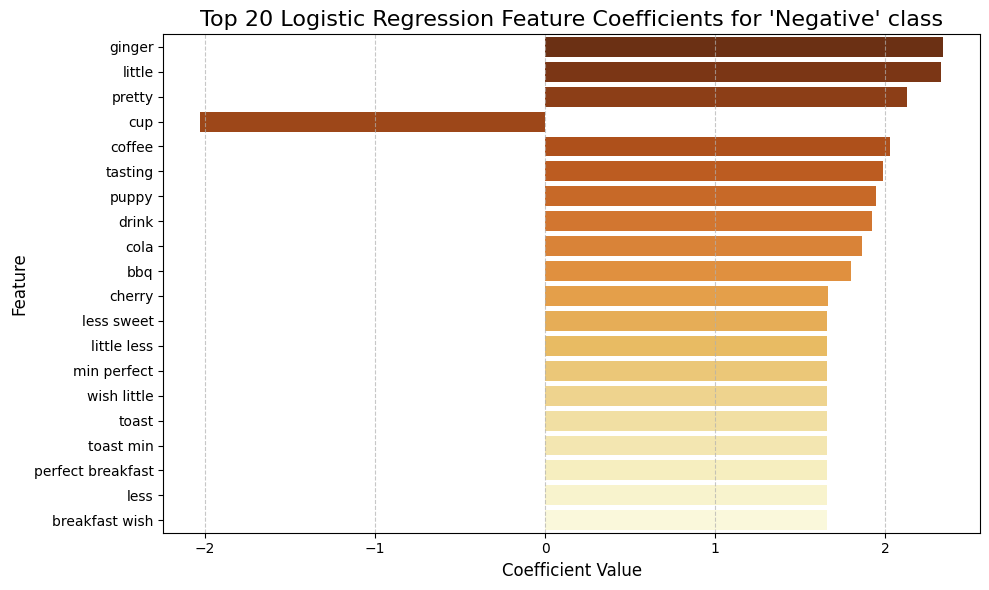

In [56]:
if all_feature_names is not None:
    coefficients = best_lr_model.named_steps['classifier'].coef_
    if coefficients.ndim > 1:
        try:
            target_class_idx = class_labels.index('Negative')
        except ValueError:
            target_class_idx = 0
        coefs = coefficients[target_class_idx]
        coef_label = f"Coefficients for '{class_labels[target_class_idx]}' class"
    else:
        coefs = coefficients[0]
        coef_label = "Coefficients"

    coef_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefs})
    coef_df['abs_coefficient'] = np.abs(coef_df['coefficient'])
    coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='coefficient', y='feature', data=coef_df, palette='YlOrBr_r')
    plt.title(f'Top 20 Logistic Regression Feature {coef_label}', fontsize=16)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Feature names not available")

In [57]:
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)

In [58]:
joblib.dump(best_lr_model, os.path.join(models_dir, 'best_logistic_regression_model.pkl'))
print(f"Best Logistic Regression model {os.path.join(models_dir, 'best_logistic_regression_model.pkl')}")

Best Logistic Regression model trained_models/best_logistic_regression_model.pkl


In [59]:
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, class_weight='balanced', probability=True))
])

In [60]:
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

In [61]:
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text_tfidf',
                                                                         TfidfVectorizer(max_features=5000,
                                                                                         ngram_range=(1,
                                                                                                      2)),
                                                                         'cleaned_text'),
                                                                        ('num_features',
                                                                         FunctionTransformer(func=<function select_numerical_features at 0x7d9396bec400>),
                                                                         ['compound',
                                                                          'pos',
                                                                          'neg',
                                                                          'neu',
                                                                          'has_negation',
                                                                          'has_intensifier',
                                                                          'Score'])])),
                                       ('classifier',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=1)

Best SVC parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}
--- Support Vector Machine Performance ---

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.67      0.71         9
     Neutral       0.00      0.00      0.00         4
    Positive       0.65      0.92      0.76        12

    accuracy                           0.68        25
   macro avg       0.47      0.53      0.49        25
weighted avg       0.58      0.68      0.62        25



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


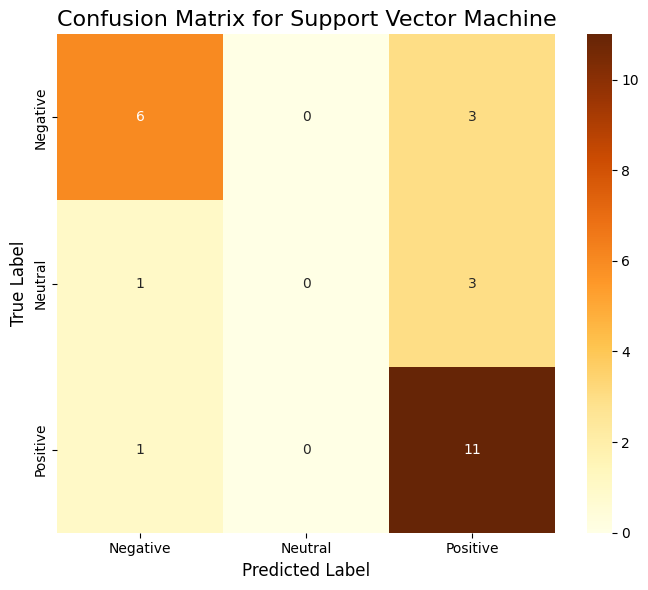

Macro F1-Score for Support Vector Machine: 0.4882


In [62]:
best_svm_model = grid_search_svm.best_estimator_
print(f"Best SVC parameters: {grid_search_svm.best_params_}")
svm_f1 = evaluate_model(best_svm_model, X_test, y_test, "Support Vector Machine", class_labels)

In [63]:
joblib.dump(best_svm_model, os.path.join(models_dir, 'best_svc_model.pkl'))
print(f"Best Support Vector Machine model saved to {os.path.join(models_dir, 'best_svc_model.pkl')}")

Best Support Vector Machine model saved to trained_models/best_svc_model.pkl


In [64]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [65]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
}

In [66]:
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text_tfidf',
                                                                         TfidfVectorizer(max_features=5000,
                                                                                         ngram_range=(1,
                                                                                                      2)),
                                                                         'cleaned_text'),
                                                                        ('num_features',
                                                                         FunctionTransformer(func=<function select_numerical_features at 0x7d9396bec400>),
                                                                         ['compound',
                                                                          'pos',
                                                                          'neg',
                                                                          'neu',
                                                                          'has_negation',
                                                                          'has_intensifier',
                                                                          'Score'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_macro', verbose=1)

Best Random Forest parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}
--- Random Forest Performance ---

Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.44      0.42         9
     Neutral       0.00      0.00      0.00         4
    Positive       0.53      0.67      0.59        12

    accuracy                           0.48        25
   macro avg       0.31      0.37      0.34        25
weighted avg       0.40      0.48      0.44        25



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


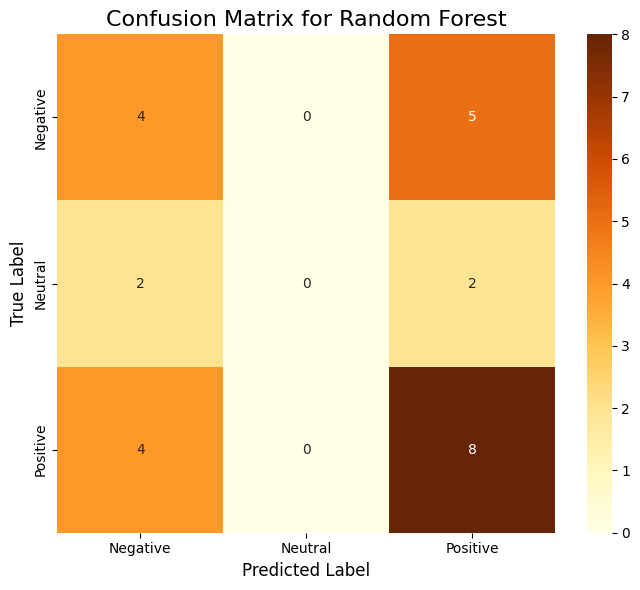

Macro F1-Score for Random Forest: 0.3379


In [67]:
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
rf_f1 = evaluate_model(best_rf_model, X_test, y_test, "Random Forest", class_labels)

/tmp/ipython-input-68-2648255597.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='YlOrBr_r')


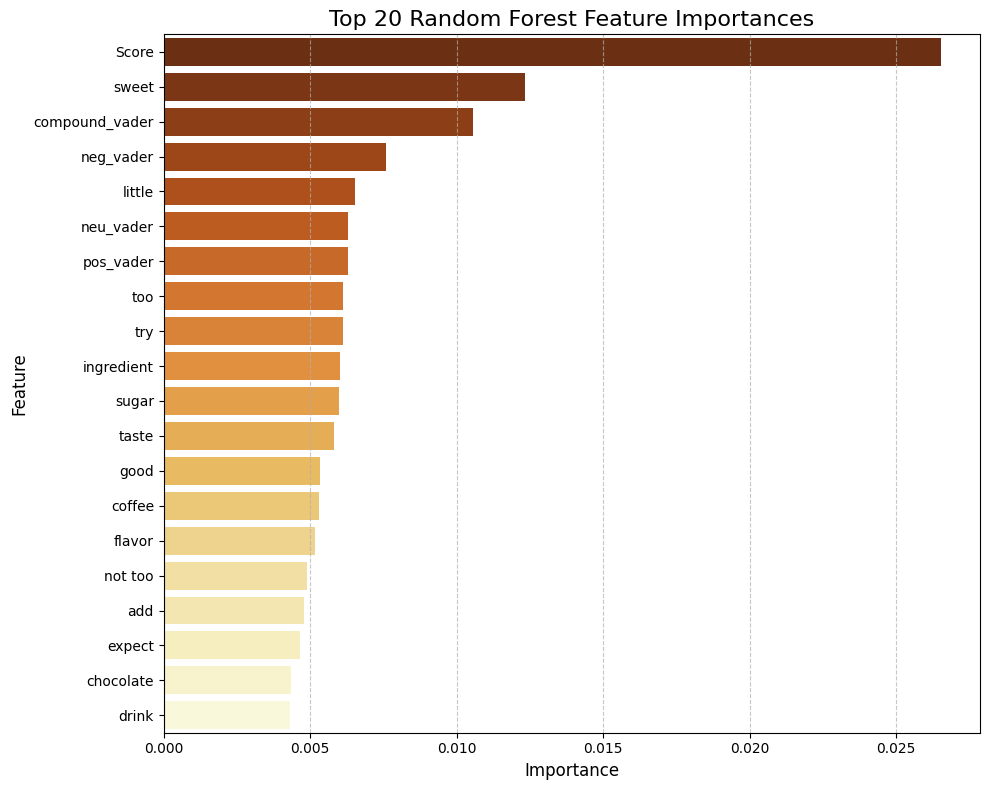

In [68]:
if all_feature_names is not None:
    feature_importances = best_rf_model.named_steps['classifier'].feature_importances_
    importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})
    importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='YlOrBr_r')
    plt.title('Top 20 Random Forest Feature Importances', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Feature names not available for visualization")


In [69]:
joblib.dump(best_rf_model, os.path.join(models_dir, 'best_random_forest_model.pkl'))
print(f"Best Random Forest model saved to {os.path.join(models_dir, 'best_random_forest_model.pkl')}")

Best Random Forest model saved to trained_models/best_random_forest_model.pkl


In [70]:
print("Macro F1-Score")
print(f"LR Macro F1: {lr_f1:.4f}")
print(f"SVC Macro F1: {svm_f1:.4f}")
print(f"RF Macro F1: {rf_f1:.4f}")

Macro F1-Score
LR Macro F1: 0.4260
SVC Macro F1: 0.4882
RF Macro F1: 0.3379


# Interactive Sentiment Analysis with Gradio

In [ ]:
import gradio as gr

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
models_dir = 'trained_models'

In [ ]:
try:
    lr_model = joblib.load(os.path.join(models_dir, 'best_logistic_regression_model.pkl'))
except FileNotFoundError:
    lr_model = None
    print("model not found")

In [ ]:
try:
    svm_model = joblib.load(os.path.join(models_dir, 'best_svc_model.pkl'))
except FileNotFoundError:
    svm_model = None
    print("SVC model not found")

In [ ]:
try:
    rf_model = joblib.load(os.path.join(models_dir, 'best_random_forest_model.pkl'))
except FileNotFoundError:
    rf_model = None
    print("Random Forest model not found")

In [ ]:
available_models = {}
if lr_model:
    available_models['Logistic Regression'] = lr_model
if svm_model:
    available_models['Support Vector Machine'] = svm_model
if rf_model:
    available_models['Random Forest'] = rf_model

In [ ]:
if not available_models:
    print("No models loaded")

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
custom_stopwords = nlp.Defaults.stop_words - {"not", "no", "nor", "never", "nothing", "nowhere", "too", "than", "some", "into", "over", "any", "few", "more", "most", "just", "very"}

In [ ]:
def clean_text_spacy(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text.lower())

    cleaned_tokens = []
    for token in doc:
        if not token.is_punct and not token.is_space and \
           token.lemma_ not in custom_stopwords and \
           len(token.lemma_) > 1:
            if token.like_num:
                continue
            cleaned_tokens.append(token.lemma_)
    return " ".join(cleaned_tokens)

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def get_vader_scores(text):
    if not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

In [ ]:
negation_words = {"not", "no", "nor", "never", "nothing", "nowhere", "hardly", "barely", "scarcely", "than", "some", "into", "over", "any", "few", "more", "most", "just"}
intensifier_words = {"very", "extremely", "highly", "really", "so", "too", "quite", "somewhat", "slightly"}

In [ ]:
def contains_negation(text, neg_words):
    tokens = text.split()
    return 1 if any(word in tokens for word in neg_words) else 0

In [ ]:
def predict_sentiment(model_name, text_input):
    if not text_input.strip():
        return "enter some text to analyze"
    if model_name not in available_models:
        return f"model '{model_name}' not loaded"

    model_pipeline = available_models[model_name]

    cleaned_text = clean_text_spacy(text_input)

    temp_df = pd.DataFrame({
        'cleaned_text': [cleaned_text],
        'Score': [3]
    })

    vader_scores_df = temp_df['cleaned_text'].apply(get_vader_scores).apply(pd.Series)
    vader_scores_df.columns = ['neg', 'neu', 'pos', 'compound']
    temp_df = pd.concat([temp_df, vader_scores_df], axis=1)

    temp_df['has_negation'] = temp_df['cleaned_text'].apply(lambda x: contains_negation(x, negation_words))
    temp_df['has_intensifier'] = temp_df['cleaned_text'].apply(lambda x: contains_intensifier(x, intensifier_words))

    input_features_df = temp_df[['cleaned_text', 'compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score']]

    try:
        processed_input = model_pipeline.named_steps['preprocessor'].transform(input_features_df)
        prediction = model_pipeline.named_steps['classifier'].predict(processed_input)[0]
        return f"Predicted Sentiment: {prediction}"
    except Exception as e:
        return f"sorry {e}"

In [ ]:
if not available_models:
    print("model loading errors")
    interface = gr.Interface(
        fn=lambda model_name, text_input: "no models loaded",
        inputs=[
            gr.Dropdown(choices=["no models available"], label="Select Model"),
            gr.Textbox(lines=5, placeholder="Paste text here...", label="Review Text")
        ],
        outputs="text",
        title="Sweetness Sentiment Analyzer (no models loaded)",
        description="check step5"
    )
else:
    interface = gr.Interface(
        fn=predict_sentiment,
        inputs=[
            gr.Dropdown(choices=list(available_models.keys()), label="Select Model", value=list(available_models.keys())[0]),
            gr.Textbox(lines=5, placeholder="How Sweet It Tastes...", label="Review Text")
        ],
        outputs="text",
        title="Don't You Know How Sweet It Tastes?",
        description="Select a trained model and paste a review to analyze its sweetness-related sentiment 🍪"
    )

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fbd4be964786d4050c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Visualization of Relevant Words for Sweetness

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

In [72]:
labeled_data_path = 'amazon-fine-food-reviews/manual_labeling_sample_done.csv'

In [73]:
try:
    df_labeled = pd.read_csv(labeled_data_path)
    if df_labeled.empty:
        print("empty")
        exit()
    df_labeled['cleaned_text'] = df_labeled['cleaned_text'].astype(str)
    df_labeled['sentiment_label'] = df_labeled['sentiment_label'].astype(str)
    print(f"Total labeled reviews: {len(df_labeled)}")
except FileNotFoundError:
    print(f"Not found")
    exit()
except KeyError as e:
    print(f"error {e}")
    exit()

Total labeled reviews: 100


In [74]:

analyzer = SentimentIntensityAnalyzer()
def get_vader_scores(text):
    if not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

In [75]:
vader_scores = df_labeled['cleaned_text'].apply(get_vader_scores).apply(pd.Series)
df_labeled = pd.concat([df_labeled, vader_scores], axis=1)

In [108]:
negation_words = {"not", "no", "nor", "never", "nothing", "nowhere", "hardly", "barely", "scarcely", "than", "some", "into", "over", "any", "few", "more", "most", "just"}
intensifier_words = {"very", "extremely", "highly", "really", "so", "too", "quite", "somewhat", "slightly"}

In [109]:
df_labeled['has_negation'] = df_labeled['cleaned_text'].apply(lambda x: contains_negation(x, negation_words))
df_labeled['has_intensifier'] = df_labeled['cleaned_text'].apply(lambda x: contains_intensifier(x, intensifier_words))

In [110]:
X = df_labeled[['cleaned_text', 'compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score']]
y = df_labeled['sentiment_label']

In [111]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
numerical_features = ['compound', 'pos', 'neg', 'neu', 'has_negation', 'has_intensifier', 'Score']

In [112]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', tfidf_vectorizer, 'cleaned_text'),
        ('num_features', 'passthrough', numerical_features)
    ],
    remainder='drop'
)

In [113]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('text_tfidf',
                                 TfidfVectorizer(max_features=5000,
                                                 ngram_range=(1, 2)),
                                 'cleaned_text'),
                                ('num_features', 'passthrough',
                                 ['compound', 'pos', 'neg', 'neu',
                                  'has_negation', 'has_intensifier',
                                  'Score'])])

In [114]:
tfidf_feature_names = preprocessor.named_transformers_['text_tfidf'].get_feature_names_out()
all_feature_names = np.concatenate([tfidf_feature_names, np.array(numerical_features)])
print(f"Total feature names: {len(all_feature_names)}")

Total feature names: 5007


In [115]:
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)
lr_model_path = os.path.join(models_dir, 'best_logistic_regression_model.pkl')

In [116]:
try:
    best_lr_model = joblib.load(lr_model_path)
    print(f"Best LR model loaded")
except FileNotFoundError:
    print(f"not found")
    exit()

Best LR model loaded


In [84]:
lr_classifier = best_lr_model.named_steps['classifier']

In [117]:
model_class_labels = lr_classifier.classes_
print(f"class order: {model_class_labels}")

class order: ['Negative' 'Neutral' 'Positive']


In [118]:
try:
    pos_idx = np.where(model_class_labels == 'Positive')[0][0]
    neg_idx = np.where(model_class_labels == 'Negative')[0][0]
except IndexError:
    print("not found")
    exit()

In [119]:
pos_coefficients = lr_classifier.coef_[pos_idx]
neg_coefficients = lr_classifier.coef_[neg_idx]

In [120]:
coef_df = pd.DataFrame({'feature': all_feature_names})
coef_df['positive_influence'] = pos_coefficients
coef_df['negative_influence'] = neg_coefficients

In [121]:
top_pos_features = coef_df.sort_values(by='positive_influence', ascending=False).head(25)

In [122]:
text_features_coef_df = coef_df[coef_df['feature'].isin(tfidf_feature_names)].copy()

In [123]:
positive_texts = df_labeled[df_labeled['sentiment_label'] == 'Positive']['cleaned_text']
negative_texts = df_labeled[df_labeled['sentiment_label'] == 'Negative']['cleaned_text']

In [124]:
positive_tfidf_matrix = preprocessor.named_transformers_['text_tfidf'].transform(positive_texts)
negative_tfidf_matrix = preprocessor.named_transformers_['text_tfidf'].transform(negative_texts)

In [125]:
feature_presence_pos = (positive_tfidf_matrix > 0).sum(axis=0).A1
feature_presence_neg = (negative_tfidf_matrix > 0).sum(axis=0).A1

In [126]:
feature_counts_pos_df = pd.DataFrame({'feature': tfidf_feature_names, 'pos_count': feature_presence_pos})
feature_counts_neg_df = pd.DataFrame({'feature': tfidf_feature_names, 'neg_count': feature_presence_neg})

In [127]:
text_features_coef_df = pd.merge(text_features_coef_df, feature_counts_pos_df, on='feature', how='left')
text_features_coef_df = pd.merge(text_features_coef_df, feature_counts_neg_df, on='feature', how='left')

In [128]:
MIN_FREQ_THRESHOLD = 5

In [129]:
top_pos_features = text_features_coef_df[
    text_features_coef_df['pos_count'] >= MIN_FREQ_THRESHOLD
].sort_values(by='positive_influence', ascending=False).head(20)

/tmp/ipython-input-130-1752342477.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='positive_influence', y='feature', data=top_pos_features, palette='YlOrBr_r')


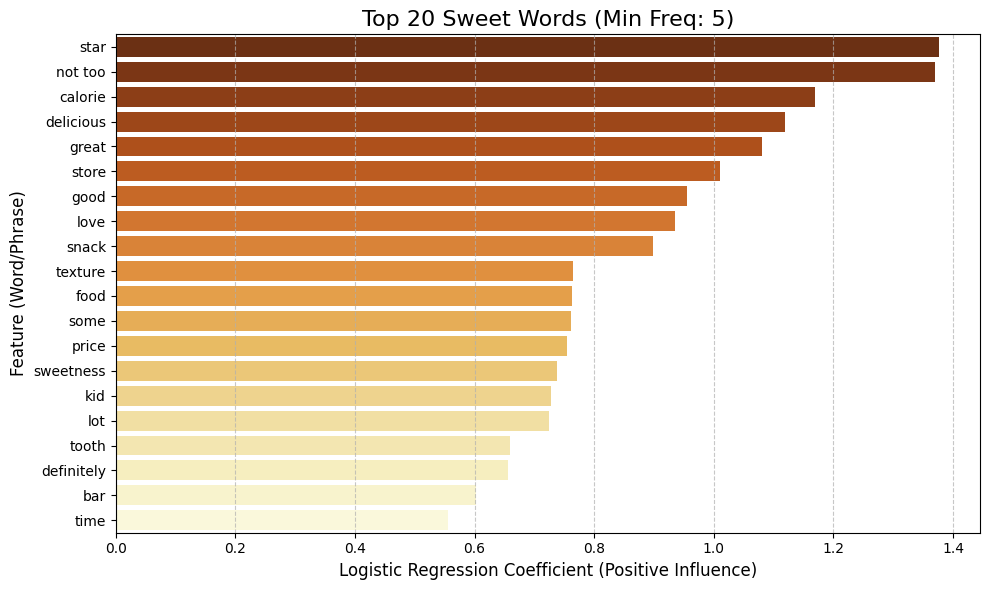

In [130]:
plt.figure(figsize=(10, 6))
sns.barplot(x='positive_influence', y='feature', data=top_pos_features, palette='YlOrBr_r')
plt.title(f'Top 20 Sweet Words (Min Freq: {MIN_FREQ_THRESHOLD})', fontsize=16)
plt.xlabel('Logistic Regression Coefficient (Positive Influence)', fontsize=12)
plt.ylabel('Feature (Word/Phrase)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [99]:
top_neg_features = text_features_coef_df[
    text_features_coef_df['neg_count'] >= MIN_FREQ_THRESHOLD
].sort_values(by='negative_influence', ascending=False).head(20)

/tmp/ipython-input-131-149220243.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='negative_influence', y='feature', data=top_neg_features, palette='YlOrBr_r')


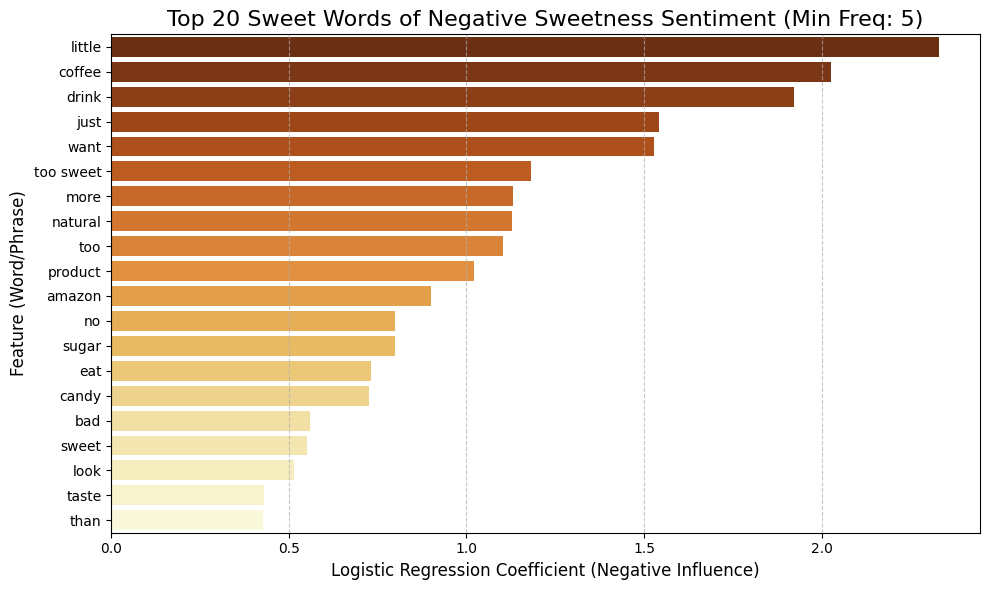

In [131]:
plt.figure(figsize=(10, 6))
sns.barplot(x='negative_influence', y='feature', data=top_neg_features, palette='YlOrBr_r')
plt.title(f'Top 20 Sweet Words of Negative Sweetness Sentiment (Min Freq: {MIN_FREQ_THRESHOLD})', fontsize=16)
plt.xlabel('Logistic Regression Coefficient (Negative Influence)', fontsize=12)
plt.ylabel('Feature (Word/Phrase)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()